In [1]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
- Distributed estimation of the centroid and the ascending direction -
"""
!python -V || python3 -V

Python 3.12.6


In [ ]:
# If executed from Google Colab --------------------------------------------------------
# !git clone https://github.com/jesusBV20/source_seeking_distr.git
# !rsync -a source_seeking_distr/ .
# !rm -r source_seeking_distr

# If you want to use latex with matplotlib ---------------------------------------------
# !apt install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super
# !pip install -y latex

In [1]:
import numpy as np
import os
import csv
import ast
import xml.etree.ElementTree as ET
import re
import sys
from tqdm import tqdm

# Graphic tools
from IPython.display import HTML
from matplotlib.animation import PillowWriter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --------------------------------------------------------------------------------------

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Scalar field functions
from sourceseeking_distr.scalar_field.sigma_common import SigmaField
from sourceseeking_distr.scalar_field.sigma_funcs import SigmaNonconvex

# Main utility functions used along the notebook
from sourceseeking_distr.toolbox.math_utils import XY_distrib, gen_random_graph, gen_Z_split
from sourceseeking_distr.toolbox.basic_utils import createDir
from sourceseeking_distr.toolbox.plot_utils import kw_def_patch, kw_def_arrow, unicycle_patch, vector2d
from sourceseeking_distr.toolbox.math_utils import unit_vec, L_sigma


# --------------------------------------------------------------------------------------

# Create the output directory
OUTPUT_FOLDER = os.path.join("..","output")
createDir(OUTPUT_FOLDER)

The directory '../output' already exists!


## Centroid estimation

In [29]:
from scipy.integrate import odeint
from matplotlib.legend import Legend # legend artist
from matplotlib.animation import FuncAnimation

# ----------------------------------------------------------------------
# Utility functions
# ----------------------------------------------------------------------

def build_B(list_edges, n):
    B = np.zeros((n,len(list_edges)))
    for i in range(len(list_edges)):
        B[list_edges[i][0]-1, i] = 1
        B[list_edges[i][1]-1, i] = -1
    return B

def build_L_from_B(B):
    L = B@B.T
    return L

def dyn_centroid_estimation(xhat_0, t, Lb, x, k=1):
    xhat_dt = - k*(Lb.dot(xhat_0) - Lb.dot(x))
    return xhat_dt

# ----------------------------------------------------------------------
# Main function
# ----------------------------------------------------------------------

def plot_centroid_estimation(ax, P, Z, C, legend=False, xlab=False, ylab=False):
    """
    Funtion that visualises the estimation of the centroid
    """
    N = P.shape[0]

    pc = np.sum(P, axis=0)/N
    scale = np.max(np.linalg.norm(P-pc,axis=1))

	# Same shape
    xc_est0 = P
    xc_est = P-C
    # print(xc_est0)
    # print(xc_est)
    # ------------------------------------------------------------------
    
    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)

	# Compute algebraic connectivity (lambda_2)
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[eig_vals > 1e-7])


    # -- Plotting --
    # Axis configuration
    ds = scale + scale/5
    ax.axis([pc[0]-ds, pc[0]+ds, pc[1]-ds, pc[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(1, min_eig_val)
    ax.set_title(title)
    
    if xlab:
       ax.set_xlabel("$X$ [L]")
    if ylab:
        ax.set_ylabel("$Y$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    for edge in Z:
        ax.plot([P[edge[0]-1,0], P[edge[1]-1,0]], [P[edge[0]-1,1], P[edge[1]-1,1]], "k--", alpha=0.6)

    # Agents
    ax.scatter(P[:,0], P[:,1], color="k", s=15)
    # phi = np.pi/3
    # for n in range(N):
    #     icon = unicycle_patch(X[n,:], phi, "royalblue", **kw_def_patch(scale))
    #     ax.add_patch(icon)

    # Points
    # ax.scatter(pc[0], pc[1], c="k", marker=r"$x$", s=scale*100, zorder=4)
    ax.scatter(xc_est0[:,0], xc_est0[:,1], c="red", marker=r"$x$", alpha=0.4, s=scale*100)
    ax.scatter(xc_est[:,0], xc_est[:,1]  , c="red", marker=r"$x$", s=scale*100)


    # Generate the legend
    if legend:
        mrk1 = plt.scatter([],[],c='k'  ,marker=r'$x$',s=60)
        mrk2 = plt.scatter([],[],c='red',marker=r'$x$',s=60)

        leg = Legend(ax, [mrk1, mrk2], 
                    [r"$p_c$ (Non-computed)",
                    r"${p_{c}}^i$: Actual computed centroid from $i$"],
                    loc="upper left", prop={'size': 12}, ncol=1)

        ax.add_artist(leg)


def plot_estimation_evolution(P, Z, C):
    """
    Funtion to visualise the estimated centroid over time
    """
    

    N = P.shape[0]

    pc = np.sum(P, axis=0)/N
    pb = P.flatten()

    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)
    
    # Compute algebraic connectivity (lambda_2)
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[eig_vals > 1e-7])

    xhat = C

    # ------------------------------------------------------------------

    # -- Plotting --
    fig = plt.figure(figsize=(10, 8))
    ax1, ax2 = fig.subplots(2,1)

    # Axis configuration
    ax1.grid(True)
    ax2.grid(True)

    title = r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(1, min_eig_val)
    ax1.set_title(title)
    
    ax2.set_xlabel("$t$ [T]")
    ax1.set_ylabel("$x$ [L]")
    ax2.set_ylabel("$y$ [L]")

    # Lines
    ax1.axhline(0, c="k", ls="-", lw=1.1)
    ax1.axvline(0, c="k", ls="-", lw=1.1)
    ax2.axhline(0, c="k", ls="-", lw=1.1)
    ax2.axvline(0, c="k", ls="-", lw=1.1)

    for i in range(P.shape[0]):
        ax1.plot(pb[2*i] - xhat[:,2*i], label=i)
        ax2.plot(pb[2*i+1] - xhat[:,2*i+1])

        ax1.legend()


def anim_centroid_estimation(P, Z, C, asc_dir, S, fps=30):
    """
    Funtion to animate the centroid estimation
    """
    
    N = P[0].shape[0]
    
    p_max = np.array([np.max(P[:,:,0]),np.max(P[:,:,1])])
    p_min = np.array([np.min(P[:,:,0]),np.min(P[:,:,1])])
    
    s_max = np.max(S[:,:])
    s_min = np.min(S[:,:][S>1e-5])

    scale = np.max(np.linalg.norm(p_max-p_min))
    
    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)

    # Compute algebraic connectivity (lambda_2)
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[eig_vals > 1e-7])

    # Simulation -------------------------------------------------------
    
    pc_hat = P-C
    mu = asc_dir
    
    pc_comp = np.average(P, axis=1)

    mu_comp = S[:,:,np.newaxis]*C
    mu_comp = np.average(mu_comp, axis=1)
    mu_comp = mu_comp/np.linalg.norm(mu_comp, axis=1, keepdims=True)
    mu_comp = mu_comp[:, np.newaxis, :]
    mu_comp = np.broadcast_to(mu_comp, mu.shape)
    
    # ------------------------------------------------------------------

    # -- Animation --
    fig = plt.figure()
    ax = fig.subplots()

    # Axis configuration
    ds = scale/4
    ax.axis([p_min[0]-ds, p_max[0]+ds, p_min[1]-ds, p_max[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(1, min_eig_val)
    ax.set_title(title)

    ax.set_xlabel("$Y$ [L]")
    ax.set_ylabel("$X$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    # Points
    pts = ax.scatter(pc_hat[0,:,0], pc_hat[0,:,1], color="r", marker=r"$x$", s=50)
    
    pts_comp = ax.scatter(pc_comp[0,0], pc_comp[0,1], color="b", marker=r"$x$", s=50)

	# Set up the normalization and colormap
    color_norm = mcolors.Normalize(vmin=s_min, vmax=s_max)
    cmap = plt.cm.get_cmap('RdYlGn_r')  # 'RdYlGn_r' is green to red
    
	# Agents
    agts = ax.scatter(P[0,:,0], P[0,:,1], c=S[0,:], s=100, cmap=cmap, norm=color_norm)
    
	# Estimated ascending direction mu
    quivers = ax.quiver(P[0,:,0], P[0,:,1], mu[0,:,0], mu[0,:,1], angles='xy', scale_units='xy', scale=0.15)
    
    # Ascending direction computed from centroid data
    quivers_comp = ax.quiver(P[0,:,0], P[0,:,1], mu_comp[0,:,0], mu_comp[0,:,1], color="r", angles='xy', scale_units='xy', scale=0.15)
    
    agt_edges = []    
    for edge in Z:
        ax.plot([P[0,edge[0]-1,0], P[0,edge[1]-1,0]], [P[0,edge[0]-1,1], P[0,edge[1]-1,1]], "k--", alpha=0.6)
        agt_edge, = ax.plot([P[0,edge[0]-1,0], P[0,edge[1]-1,0]], [P[0,edge[0]-1,1], P[0,edge[1]-1,1]], "k--")
        agt_edges.append(agt_edge)

    # -- Building the animation --
    anim_frames = C.shape[0]

    # Function to update the animation
    def animate(i):
        # Update the centroid estimation markers
        pts.set_offsets(pc_hat[i])
        pts_comp.set_offsets(pc_comp[i])
        agts.set_offsets(P[i])
        agts.set_array(S[i,:])
        for agt_edge, edge in zip(agt_edges, Z):
            agt_edge.set_data([P[i,edge[0]-1,0], P[i,edge[1]-1,0]], [P[i,edge[0]-1,1], P[i,edge[1]-1,1]])
        
        quivers.set_offsets(P[i])
        quivers.set_UVC(mu[i,:,0], mu[i,:,1])
        
        quivers_comp.set_offsets(P[i])
        quivers_comp.set_UVC(mu_comp[i,:,0], mu_comp[i,:,1])

        # Update the title
        title = r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(1, min_eig_val)
        ax.set_title(title)

    # Generate the animation
    print("Simulating {0:d} frames...".format(anim_frames))
    anim = FuncAnimation(fig, animate, frames=tqdm(range(anim_frames), initial=1, position=0), 
                         interval=1/fps*1000)
    anim.embed_limit = 40

    # Close plots and return the animation class to be compiled
    plt.close()
    return anim

## Data input

In [3]:
def parse_value(value):
    """Parse the value to detect and handle points in space (comma-separated values)."""
    try:
        # Check if the value contains a comma, indicating a point in space
        if ',' in value:
            # Use ast.literal_eval to safely evaluate the string as a tuple, then convert to a NumPy array
            parsed_value = np.array(ast.literal_eval(f'({value})'))
            return parsed_value
        else:
            # If not a point, return the value as a float
            return float(value)
    except ValueError:
        # Return the original string if it can't be converted to a float or point
        return value

def load_csv_to_dict(filename):
    """Load a CSV file into a dictionary with lists of parsed values."""
    data_dict = {}
    
    # Open the CSV file with tab delimiter
    with open(filename, mode='r') as csvfile:
        csvreader = csv.DictReader(csvfile, delimiter='\t')
        
        # Initialize dictionary keys using the CSV headers
        for header in csvreader.fieldnames:
            data_dict[header] = []
        
        # Fill the dictionary with parsed data
        for row in csvreader:
            for header in csvreader.fieldnames:
                data_dict[header].append(parse_value(row[header]))
    
    return data_dict

def convert_dict_to_numpy_arrays(data_dict):
    """Convert lists in the dictionary to appropriate NumPy arrays or keep them as lists if necessary."""
    numpy_arrays = {}
    for key, value in data_dict.items():
        # Check if the list contains only scalars
        if all(isinstance(v, (float, int)) for v in value):
            numpy_arrays[key] = np.array(value)
        else:
            numpy_arrays[key] = value  # Keep the list as is if it contains arrays or mixed types
    return numpy_arrays

def load_all_csv_in_folder(folder_path):
    """Load all CSV files in the specified folder into a dictionary with their data."""
    all_data = {}
    
    # List all CSV files in the given folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            # Get the full file path
            file_path = os.path.join(folder_path, file_name)
            
            # Load CSV data into a dictionary
            data_dict = load_csv_to_dict(file_path)
            
            # Convert the dictionary to appropriate NumPy arrays or lists
            numpy_arrays = convert_dict_to_numpy_arrays(data_dict)
            
            # Store the result in the all_data dictionary, using the file name (without extension) as the key
            
            file_date, file_id = extract_date_and_id_from_filename(file_name)
                
            if file_date not in all_data:
                all_data[file_date] = {}
            
            if file_id not in all_data[file_date]:
                all_data[file_date][file_id] = {}
                
            all_data[file_date][file_id] = numpy_arrays
                
    
    return all_data

def extract_date_and_id_from_filename(filename):
    """Extract the date and ID from the filename in the format [date]_[time]_[id].csv."""
    match = re.match(r"(\d{2}_\d{2}_\d{2}__\d{2}_\d{2}_\d{2})_(\d+)", filename)
    if match:
        date = match.group(1)
        file_id = match.group(2)
        return date, file_id
    return None, None

In [4]:
folder_path = '../input_data'
loaded_data = load_all_csv_in_folder(folder_path)

### Some examples

0 :  [1 1]
1 :  [1 2]
2 :  [2 1]


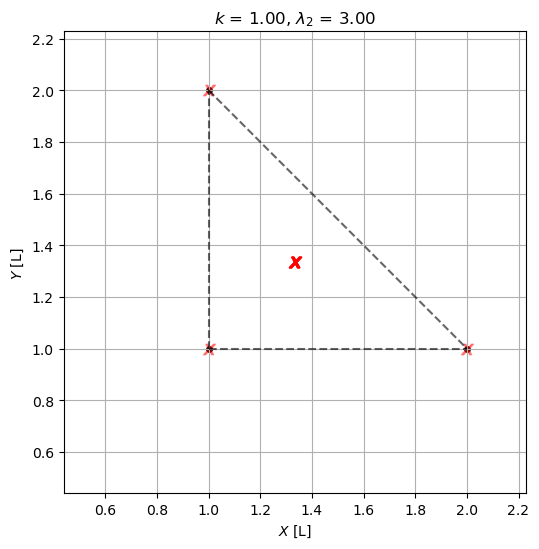

In [5]:
## Parameters #####

p = np.array([[1,1], [1,2], [2,1]])
c = np.array([[-1/3,-1/3], [-1/3,2/3], [2/3,-1/3]])
Z = ((1,2), (2,3), (1,3))


# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(10, 6), dpi=100)
ax  = fig.subplots()

for i in range(p.shape[0]):
    print(i,": ", p[i,:])
plot_centroid_estimation(ax, p, Z, c, legend=False, xlab=True, ylab=True)

# plot_estimation_evolution(p, Z, c)

# Show the plot!
plt.show()

In [31]:
p = []
c = []
s = []
l = []
Z = ((1,2), (1,3))
for file_id, file_data in loaded_data["24_09_13__12_09_10"].items():
    p.append(np.array(file_data["DWM1001_DATA:enu_pos"]))
    c.append(np.array(file_data["DWM1001_DATA:centroid"]))
    s.append(np.array(file_data["DWM1001_DATA:sigma"]))
    l.append(np.array(file_data["DWM1001_DATA:asc_dirc"]))
    
min_size = min(len(arr) for arr in p)
p = np.array([arr[:min_size] for arr in p])
p = np.stack(p, axis=1)
c = np.array([arr[:min_size] for arr in c])
c = np.stack(c, axis=1)
s = np.array([arr[:min_size] for arr in s])
s = np.stack(s, axis=1)
l = np.array([arr[:min_size] for arr in l])
l = np.stack(l, axis=1)

anim = anim_centroid_estimation(p, Z, c, l, s)
# HTML(anim.to_html5_video()) # It takes a loooot of time...

writer = PillowWriter(fps=15, bitrate=1800)
anim.save(os.path.join(OUTPUT_FOLDER, "centroid1.gif"),
        writer = writer)

/tmp/ipykernel_3719/3060385217.py:184: RuntimeWarning: invalid value encountered in divide
  mu_comp = mu_comp/np.linalg.norm(mu_comp, axis=1, keepdims=True)
/tmp/ipykernel_3719/3060385217.py:217: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')  # 'RdYlGn_r' is green to red


Simulating 3003 frames...


 52%|█████▏    | 1575/3003 [01:12<01:01, 23.21it/s]